- [Base Model (XGBoost)](#Base-Model---XGBoost)
- [Base Model (NN)](#Base-Model---NN)
- [NN with Entity Embedding](#NN-with-Entity-Embedding)
- [Comparison](#Comparison)
- [XGBoost Using Entity Embedding](#XGBoost-Using-Entity-Embedding)
- [References](#References)

Using **[Diamonds](https://ggplot2.tidyverse.org/reference/diamonds.html)** sample datasets, we will implement **[Entity Embedding for Categorical Variables](https://github.com/entron/entity-embedding-rossmann)** and validate the effect on the evaluation.

In [138]:
import os
import gc
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from tensorflow import set_random_seed; set_random_seed(42)

# from keras.models import Model
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Activation, Merge
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
diamonds = sns.load_dataset("diamonds")

print(diamonds.shape)
diamonds.head()

(53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Base Model - XGBoost

In [84]:
diamonds = sns.load_dataset("diamonds")

def feature_engineering(data):
    for col in data.columns:
        if type(data[col].iloc[0]) == str:
            le = LabelEncoder()
            data[col] = le.fit_transform(np.array(data[col]))
    return data


diamonds = feature_engineering(diamonds)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [85]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

params = {
          "objective": "reg:linear",
          "eval_metric": "mae",
          "nthread": 4,
          "learning_rate": 0.05,
          "min_child_weight": 0,
          "max_depth": 8,
          "gamma": 0,
          "subsample":0.9,
          "colsample_bytree": 0.9,
          "reg_lambda": 0,
          "silent": 1,
          "seed": 42
         }

def MAPE(trues, preds):
    return np.mean(np.absolute(trues - preds)/trues)

def modeling_xgb(data, params):
    ## Prepare for Xgboost
    #Split dataset to train and test data: Hold-Out
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["price", "x", "y", "z"], axis=1), data["price"], test_size=0.2, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
    print("学習データ数: {}, 検証データ数: {}, テストデータ数: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))
    print("X_train: {}\ny_train:{}".format(X_train.iloc[0], y_train.iloc[0]))
    #Get labels
    feature_names = np.array(X_train.columns)
    #Change data-type to matrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.tolist(), feature_names = feature_names)
    dvalid = xgb.DMatrix(X_valid.values, label=y_valid.tolist(), feature_names = feature_names)
    dtest = xgb.DMatrix(X_test.values, label=y_test.tolist(), feature_names = feature_names)
    
    print("process training..  ")
    model = xgb.train(params, dtrain, num_boost_round=4000, evals=[(dtrain, 'train'), (dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=100)
    
    print("process evaluation...  ")
    pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    
    MAE_valid = mean_absolute_error(y_valid, pred_valid)
    MAE_test = mean_absolute_error(y_test, pred_test)
    MAPE_valid = MAPE(y_valid, pred_valid)
    MAPE_test = MAPE(y_test, pred_test)
    
    #結果出力用
    df_valid = pd.DataFrame(data = {
        "y_valid": y_valid,
        "pred_valid": pred_valid
    })
    df_test = pd.DataFrame(data = {
        "y_test": y_test,
        "pred_test": pred_test
    })
    
    print("MAE_valid：{}  ".format(round(MAE_valid)) )
    print("MAE_test：{}  ".format(round(MAE_test)) )
    print("MAPE_valid：{}  ".format(round(MAPE_valid,4)) )
    print("MAPE_test：{}  ".format(round(MAPE_test,4)) )
    
    return df_valid, df_test

df_valid_xgb, df_test_xgb = modeling_xgb(diamonds, params)

学習データ数: 34521, 検証データ数: 8631, テストデータ数: 10788
X_train: carat       1.16
cut         1.00
color       2.00
clarity     3.00
depth      60.80
table      65.00
Name: 6881, dtype: float64
y_train:4131
process training..
[0]	train-mae:3754.57	eval-mae:3691.36
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:278.045	eval-mae:304.577
[200]	train-mae:231.23	eval-mae:277.039
[300]	train-mae:219.739	eval-mae:275.447
[400]	train-mae:208.701	eval-mae:274.647
[500]	train-mae:195.299	eval-mae:274.452
[600]	train-mae:184.048	eval-mae:274.962
Stopping. Best iteration:
[512]	train-mae:194.268	eval-mae:274.224

process evaluation...
MAE_valid：274.0  
MAE_test：273.0  
MAPE_valid：0.0786  
MAPE_test：0.0787  
CPU times: user 11.2 s, sys: 1.05 s, total: 12.2 s
Wall time: 5.87 s


In [199]:
# Stopping. Best iteration:
# [512]	train-mae:194.268	eval-mae:274.224
print( MAPE(df_test_xgb.y_test, df_test_xgb.pred_test) )
print( mean_absolute_error(df_test_xgb.y_test, df_test_xgb.pred_test) )

0.07873968862328322
273.2616665507406


## Base Model - NN

In [168]:
%%time
diamonds = sns.load_dataset("diamonds")

def csv2dicts(df):
    data = []
    keys = []
    for i in range(len(diamonds)):
        if i == 0:
            keys = diamonds.columns.tolist()
            print("columns:", keys)
        if i % 10000 == 0:
            print(i, "/", len(diamonds))
        arr = diamonds.iloc[i]
        data.append({key: value for key, value in zip(keys, arr)})
    return data

def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x
    return data
        
data = csv2dicts(diamonds)
print(data[0])



def feature_list(record, features):
    fl=[]
    for feature in features:
        fl += [record[feature]]
    return fl

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def prepare_features(data, features):
    train_X = []
    train_y = []
    for record in data:
        fl = feature_list(record, features)
        train_X += [fl]
        train_y += [int(float(record["price"]))]
    print("Number of train datapoints: ", len(train_y))
    print("train_y MIN:", min(train_y), "train_y MAX:", max(train_y))
    # categorical variables -> One-Hot Encoding
    train_X = pd.DataFrame(np.array(train_X), columns=features).astype({"carat":float, "depth":float, "table":float})
    train_X, new_columns = one_hot_encoder(train_X)
    new_features = train_X.columns.tolist()
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    print(train_X[0], train_y[0])
    return train_X, train_y, new_features
    
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']
X, y, features = prepare_features(data, features)

columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
0 / 53940
10000 / 53940
20000 / 53940
30000 / 53940
40000 / 53940
50000 / 53940
{'carat': 0.23, 'cut': 'Ideal', 'color': 'E', 'clarity': 'SI2', 'depth': 61.5, 'table': 55.0, 'price': 326, 'x': 3.95, 'y': 3.98, 'z': 2.43}
Number of train datapoints:  53940
train_y MIN: 326 train_y MAX: 18823
[ 0.23 61.5  55.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.  ] 326
CPU times: user 10.1 s, sys: 247 ms, total: 10.3 s
Wall time: 12.8 s


In [177]:
def split_features(X):
    X_list = []

    carat = X[..., [0]]
    X_list.append(carat)

    cut = X[..., [1]]
    X_list.append(cut)

    color = X[..., [2]]
    X_list.append(color)

    clarity = X[..., [3]]
    X_list.append(clarity)

    depth = X[..., [4]]
    X_list.append(depth)

    table = X[..., [5]]
    X_list.append(table)

    return X_list


class Model(object):

    def evaluate(self, X_val, y_val):
        assert(min(y_val) > 0)
        guessed_sales = self.guess(X_val)
        relative_err = np.absolute((y_val - guessed_sales) / y_val)
        result = np.sum(relative_err) / len(y_val)
        return result
    
    
class NN(Model):

    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.epochs = 1000
        self.batch_size = 128
        self.input_dim = X_train.shape[1]
        self.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')  # https://github.com/keras-team/keras/issues/2159
        self.max_log_y = max(np.max(np.log(y_train)), np.max(np.log(y_val)))
        self.__build_keras_model()
        self.fit(X_train, y_train, X_val, y_val)

    def __build_keras_model(self):
        self.model = Sequential()
        self.model.add(Dense(512, kernel_initializer="he_normal", input_dim=self.input_dim))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.2))
        self.model.add(BatchNormalization())
        self.model.add(Dense(128, kernel_initializer="he_normal"))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.2))
        self.model.add(BatchNormalization())
        self.model.add(Dense(1))
#         self.model.add(Activation('sigmoid'))

        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def _val_for_fit(self, val):
        val = np.log(val) / self.max_log_y
        return val

    def _val_for_pred(self, val):
        return np.exp(val * self.max_log_y)

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(X_train, self._val_for_fit(y_train),
                       validation_data=(X_val, self._val_for_fit(y_val)),
                       epochs=self.epochs, batch_size=self.batch_size,
                       callbacks=[self.early_stopping],
                       # callbacks=[self.checkpointer],
                       )
        # self.model.load_weights('best_model_weights.hdf5')
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, features):
        result = self.model.predict(features).flatten()
        return self._val_for_pred(result)
    
    

In [178]:
def model(X,y):
    train_ratio = 0.8
    shuffle_data = True
    standardize = True
    num_records = len(X)
    train_size = int(train_ratio * num_records)
    
    if shuffle_data:
        print("Using shuffled data")
        sh = np.arange(X.shape[0])
        np.random.seed(seed=42)
        np.random.shuffle(sh)
        X = X[sh]
        y = y[sh]
        print(sh)
        
    X_train = X[:train_size]
    X_val = X[train_size:]
    y_train = y[:train_size]
    y_val = y[train_size:]
    print("Number of samples used for training: " + str(y_train.shape[0]))
    
    standardize_list = []
    if standardize:
        print("Using standardized data")
        carat_mean = np.mean(X_train[:, 0])
        carat_std = np.std(X_train[:, 0])
        X_train[:,0] = (X_train[:,0] - carat_mean)/carat_std
        X_val[:,0] = (X_val[:,0] - carat_mean)/carat_std
        depth_mean = np.mean(X_train[:, 1])
        depth_std = np.std(X_train[:, 1])
        X_train[:,1] = (X_train[:,1] - depth_mean)/depth_std
        X_val[:,1] = (X_val[:,1] - depth_mean)/depth_std
        table_mean = np.mean(X_train[:, 2])
        table_std = np.std(X_train[:, 2])
        X_train[:,2] = (X_train[:,2] - table_mean)/table_std
        X_val[:,2] = (X_val[:,2] - table_mean)/table_std
        for m, s in zip([carat_mean, depth_mean, table_mean], [carat_std, depth_std, table_std]):
            standardize_list.append([m,s])
    
    print("Fitting NN...")
    models = []
    iter_N = 1
    for i in range(iter_N):
        print("iteration: {}/{}".format(i+1, iter_N))
        models.append(NN(X_train, y_train, X_val, y_val))
        
    def evaluate_models(models, X, y):
        assert(min(y) > 0)
        guessed_y = np.array([model.guess(X) for model in models])
        mean_y = guessed_y.mean(axis=0)
        relative_err = np.absolute((y - mean_y) / y)
        result = np.sum(relative_err) / len(y)
        return result, y, mean_y
    
    print("Evaluate combined models...")
    print("Training error...")
    train_score, train_y, train_pred = evaluate_models(models, X_train, y_train)
    print(train_score)

    print("Validation error...")
    val_score, val_y, val_pred = evaluate_models(models, X_val, y_val)
    print(val_score)
    
    return train_y, train_pred, val_y, val_pred, models, standardize_list
    

train_y_nn, train_pred_nn, val_y_nn, val_pred_nn, models_nn, standardize_list = model(X, y)
df_test_nn = pd.DataFrame({"val_y": val_y_nn, "val_pred": val_pred_nn})        

Using shuffled data
[ 1388 50052 41645 ... 38158   860 15795]
Number of samples used for training: 43152
Using standarized data
Fitting NN...
iteration: 1/1
Train on 43152 samples, validate on 10788 samples
Epoch 1/1000
43152/43152 [==============================] - 14s 325us/step - loss: 0.3675 - val_loss: 0.0542
Epoch 2/1000
43152/43152 [==============================] - 4s 93us/step - loss: 0.0839 - val_loss: 0.0253
Epoch 3/1000
43152/43152 [==============================] - 4s 87us/step - loss: 0.0448 - val_loss: 0.0164
Epoch 4/1000
43152/43152 [==============================] - 4s 84us/step - loss: 0.0344 - val_loss: 0.0143
Epoch 5/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0280 - val_loss: 0.0116
Epoch 6/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0250 - val_loss: 0.0171
Epoch 7/1000
43152/43152 [==============================] - 4s 87us/step - loss: 0.0234 - val_loss: 0.0191
Epoch 8/1000
43152/43152 [================

43152/43152 [==============================] - 3s 75us/step - loss: 0.0137 - val_loss: 0.0115
Epoch 76/1000
43152/43152 [==============================] - 3s 66us/step - loss: 0.0135 - val_loss: 0.0102
Epoch 77/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0134 - val_loss: 0.0084
Epoch 78/1000
43152/43152 [==============================] - 3s 71us/step - loss: 0.0135 - val_loss: 0.0084
Epoch 79/1000
43152/43152 [==============================] - 3s 66us/step - loss: 0.0134 - val_loss: 0.0079
Epoch 80/1000
43152/43152 [==============================] - 3s 66us/step - loss: 0.0134 - val_loss: 0.0081
Epoch 81/1000
43152/43152 [==============================] - 3s 70us/step - loss: 0.0132 - val_loss: 0.0104
Epoch 82/1000
43152/43152 [==============================] - 3s 70us/step - loss: 0.0132 - val_loss: 0.0084
Epoch 83/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0136 - val_loss: 0.0081
Epoch 84/1000
43152/43152 [===============

43152/43152 [==============================] - 4s 87us/step - loss: 0.0134 - val_loss: 0.0082
Epoch 151/1000
43152/43152 [==============================] - 4s 101us/step - loss: 0.0131 - val_loss: 0.0077
Epoch 152/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0126 - val_loss: 0.0080
Epoch 153/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0132 - val_loss: 0.0114
Epoch 154/1000
43152/43152 [==============================] - 4s 96us/step - loss: 0.0131 - val_loss: 0.0091
Epoch 155/1000
43152/43152 [==============================] - 4s 98us/step - loss: 0.0129 - val_loss: 0.0087
Epoch 156/1000
43152/43152 [==============================] - 4s 85us/step - loss: 0.0136 - val_loss: 0.0081
Epoch 157/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0134 - val_loss: 0.0083
Epoch 158/1000
43152/43152 [==============================] - 4s 101us/step - loss: 0.0131 - val_loss: 0.0081
Epoch 159/1000
43152/43152 [====

43152/43152 [==============================] - 3s 72us/step - loss: 0.0129 - val_loss: 0.0083
Epoch 226/1000
43152/43152 [==============================] - 3s 73us/step - loss: 0.0129 - val_loss: 0.0087
Epoch 227/1000
43152/43152 [==============================] - 3s 74us/step - loss: 0.0132 - val_loss: 0.0083
Epoch 228/1000
43152/43152 [==============================] - 3s 68us/step - loss: 0.0134 - val_loss: 0.0113
Epoch 229/1000
43152/43152 [==============================] - 3s 70us/step - loss: 0.0132 - val_loss: 0.0109
Epoch 230/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0128 - val_loss: 0.0080
Epoch 231/1000
43152/43152 [==============================] - 3s 67us/step - loss: 0.0130 - val_loss: 0.0116
Epoch 232/1000
43152/43152 [==============================] - 3s 70us/step - loss: 0.0133 - val_loss: 0.0122
Epoch 233/1000
43152/43152 [==============================] - 3s 71us/step - loss: 0.0127 - val_loss: 0.0082
Epoch 234/1000
43152/43152 [======

43152/43152 [==============================] - 3s 75us/step - loss: 0.0126 - val_loss: 0.0083
Epoch 301/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0128 - val_loss: 0.0088
Epoch 302/1000
43152/43152 [==============================] - 5s 105us/step - loss: 0.0127 - val_loss: 0.0084
Epoch 303/1000
43152/43152 [==============================] - 5s 110us/step - loss: 0.0131 - val_loss: 0.0085
Epoch 304/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0129 - val_loss: 0.0085
Epoch 305/1000
43152/43152 [==============================] - 4s 97us/step - loss: 0.0126 - val_loss: 0.0097
Epoch 306/1000
43152/43152 [==============================] - 5s 110us/step - loss: 0.0131 - val_loss: 0.0099
Epoch 307/1000
43152/43152 [==============================] - 5s 115us/step - loss: 0.0131 - val_loss: 0.0087
Result on validation data:  0.08286001534944269
Evaluate combined models...
Training error...
0.0806033205703031
Validation error...
0.0828

In [180]:
# epoch=1000 + EarlyStopping=200, batch_size=128, 512->128, dropout=0.2, Dense
# Epoch 307/1000
# 43152/43152 [==============================] - 5s 115us/step - loss: 0.0131 - val_loss: 0.0087
# Result on validation data:  0.08286001534944269
print( MAPE(val_y_nn, val_pred_nn) )
print(mean_absolute_error(val_y_nn, val_pred_nn))

0.08286001534944269
324.6301409643935


## NN with Entity Embedding

In [185]:
%%time
diamonds = sns.load_dataset("diamonds")

def csv2dicts(df):
    data = []
    keys = []
    for i in range(len(diamonds)):
        if i == 0:
            keys = diamonds.columns.tolist()
            print("columns:", keys)
        if i % 10000 == 0:
            print(i, "/", len(diamonds))
        arr = diamonds.iloc[i]
        data.append({key: value for key, value in zip(keys, arr)})
    return data

def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x
        
        
data = csv2dicts(diamonds)
print(data[0])

columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
0 / 53940
10000 / 53940
20000 / 53940
30000 / 53940
40000 / 53940
50000 / 53940
{'carat': 0.23, 'cut': 'Ideal', 'color': 'E', 'clarity': 'SI2', 'depth': 61.5, 'table': 55.0, 'price': 326, 'x': 3.95, 'y': 3.98, 'z': 2.43}
CPU times: user 9.6 s, sys: 149 ms, total: 9.75 s
Wall time: 10.5 s


In [187]:
def feature_list(record, features):
    fl=[]
    for feature in features:
        fl += [record[feature]]
    return fl

def prepare_features(data, features):
    train_X = []
    train_y = []
    for record in data:
        fl = feature_list(record, features)
        train_X += [fl]
        train_y += [int(float(record["price"]))]
    print("Number of train datapoints: ", len(train_y))
    print("train_y MIN:", min(train_y), "train_y MAX:", max(train_y))
    
    train_X = np.array(train_X)
    full_X = train_X.copy()
    les = []
    for i in range(train_X.shape[1]):
        try: 
            float(full_X[0, i][0])
        except:
            print(features[i], "is encoded")
            le = LabelEncoder()
            le.fit(full_X[:, i])
            train_X[:, i] = le.transform(train_X[:, i])
            les.append(le.fit_transform(full_X[:, i]))

    train_X = train_X.astype(float)
#     train_X = train_X.astype(int)
    train_y = np.array(train_y)
    print(train_X[0], train_y[0])
    
    return train_X, train_y, les
    
    
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']
X, y, les = prepare_features(data, features)

Number of train datapoints:  53940
train_y MIN: 326 train_y MAX: 18823
cut is encoded
color is encoded
clarity is encoded
[ 0.23  2.    1.    3.   61.5  55.  ] 326


In [188]:
def split_features(X):
    X_list = []

    carat = X[..., [0]]
    X_list.append(carat)

    cut = X[..., [1]]
    X_list.append(cut)

    color = X[..., [2]]
    X_list.append(color)

    clarity = X[..., [3]]
    X_list.append(clarity)

    depth = X[..., [4]]
    X_list.append(depth)

    table = X[..., [5]]
    X_list.append(table)

    return X_list

class Model(object):

    def evaluate(self, X_val, y_val):
        assert(min(y_val) > 0)
        guessed_sales = self.guess(X_val)
        relative_err = np.absolute((y_val - guessed_sales) / y_val)
        result = np.sum(relative_err) / len(y_val)
        return result

class NN_with_EntityEmbedding(Model):

    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.epochs = 1000
        self.batch_size = 128
        self.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')  # https://github.com/keras-team/keras/issues/2159
        self.max_log_y = max(np.max(np.log(y_train)), np.max(np.log(y_val)))
        self.__build_keras_model()
        self.fit(X_train, y_train, X_val, y_val)

    def preprocessing(self, X):
        X_list = split_features(X)
        return X_list
    
    def Embedding_inOut(self, input_len, output_len, layer_name):
        input_col = Input(shape=(1,))
        output_col = Embedding(input_len, output_len, name=layer_name)(input_col)
        output_col = Reshape(target_shape=(output_len,))(output_col)
        return input_col, output_col
    
    def Dense_inOut(self, output_len, layer_name):
        input_col = Input(shape=(1,))
        output_col = Dense(output_len)(input_col)
        return input_col, output_col

    def __build_keras_model(self):
        input_carat, output_carat = self.Dense_inOut(1, "carat_embedding")  # 274
        input_cut, output_cut = self.Embedding_inOut(5, 4, "cut_embedding")
        input_color, output_color = self.Embedding_inOut(7, 6, "color_embedding")
        input_clarity, output_clarity = self.Embedding_inOut(8, 7, "clarity_embedding")
        input_depth, output_depth = self.Dense_inOut(1, "depth_embedding")  # 184
        input_table, output_table = self.Dense_inOut(1, "table_embedding")  # 128

        input_model = [input_carat, input_cut, input_color, input_clarity, input_depth, input_table]
        output_embeddings = [output_carat, output_cut, output_color, output_clarity, output_depth, output_table]

        output_model = Concatenate()(output_embeddings)
        output_model = Dense(512, kernel_initializer="he_normal")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dropout(0.2)(output_model)
        output_model = BatchNormalization()(output_model)
        output_model = Dense(128, kernel_initializer="he_normal")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dropout(0.2)(output_model)
        output_model = BatchNormalization()(output_model)
        output_model = Dense(1)(output_model)
        # output_model = Activation('sigmoid')(output_model)

        self.model = KerasModel(inputs=input_model, outputs=output_model)

        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def _val_for_fit(self, val):
        val = np.log(val) / self.max_log_y
        return val

    def _val_for_pred(self, val):
        return np.exp(val * self.max_log_y)

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(self.preprocessing(X_train), self._val_for_fit(y_train),
                       validation_data=(self.preprocessing(X_val), self._val_for_fit(y_val)),
                       epochs=self.epochs, batch_size=self.batch_size,
                       callbacks=[self.early_stopping],
                       # callbacks=[self.checkpointer],
                       )
        # self.model.load_weights('best_model_weights.hdf5')
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, features):
        features = self.preprocessing(features)
        result = self.model.predict(features).flatten()
        return self._val_for_pred(result)

In [189]:
# %%time
def model(X, y):
    train_ratio = 0.8
    shuffle_data = True
    embeddings_as_input = False
    one_hot_as_input = False
    standardize = True
    save_embeddings = True
    saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file
    
    num_records = len(X)
    train_size = int(train_ratio * num_records)
    
    if shuffle_data:
        print("Using shuffled data")
        sh = np.arange(X.shape[0])
        np.random.seed(seed=42)
        np.random.shuffle(sh)
        X = X[sh]
        y = y[sh]
        print(sh)

    if embeddings_as_input:
        print("Using learned embeddings as input")
        X = embed_features(X, saved_embeddings_fname)

    if one_hot_as_input:
        print("Using one-hot encoding as input")
        enc = OneHotEncoder(sparse=False)
        enc.fit(X)
        X = enc.transform(X)
    
    X_train = X[:train_size]
    X_val = X[train_size:]
    y_train = y[:train_size]
    y_val = y[train_size:]
    print("Number of samples used for training: " + str(y_train.shape[0]))
    
    standardize_list = []
    if standardize:
        print("Using standardized data")
        carat_mean = np.mean(X_train[:, 0])
        carat_std = np.std(X_train[:, 0])
        X_train[:,0] = (X_train[:,0] - carat_mean)/carat_std
        X_val[:,0] = (X_val[:,0] - carat_mean)/carat_std
        depth_mean = np.mean(X_train[:, 4])
        depth_std = np.std(X_train[:, 4])
        X_train[:,4] = (X_train[:,4] - depth_mean)/depth_std
        X_val[:,4] = (X_val[:,4] - depth_mean)/depth_std
        table_mean = np.mean(X_train[:, 5])
        table_std = np.std(X_train[:, 5])
        X_train[:,5] = (X_train[:,5] - table_mean)/table_std
        X_val[:,5] = (X_val[:,5] - table_mean)/table_std
        for m, s in zip([carat_mean, depth_mean, table_mean], [carat_std, depth_std, table_std]):
            standardize_list.append([m,s])
    
    print("Fitting NN_with_EntityEmbedding...")
    models = []
    iter_N = 1
    for i in range(iter_N):
        print("iteration: {}/{}".format(i+1, iter_N))
        models.append(NN_with_EntityEmbedding(X_train, y_train, X_val, y_val))
    
    if save_embeddings:
        model = models[0].model
#         carat_embedding = model.get_layer('carat_embedding').get_weights()[0]
        cut_embedding = model.get_layer('cut_embedding').get_weights()[0]
        color_embedding = model.get_layer('color_embedding').get_weights()[0]
        clarity_embedding = model.get_layer('clarity_embedding').get_weights()[0]
#         depth_embedding = model.get_layer('depth_embedding').get_weights()[0]
#         table_embedding = model.get_layer('table_embedding').get_weights()[0]
        
#         list_embedding = [carat_embedding, cut_embedding, color_embedding, clarity_embedding, depth_embedding, table_embedding]
        list_embedding = [cut_embedding, color_embedding, clarity_embedding]
        with open(saved_embeddings_fname, 'wb') as f:
            pickle.dump(list_embedding, f, -1)
            
    def evaluate_models(models, X, y):
        assert(min(y) > 0)
        guessed_y = np.array([model.guess(X) for model in models])
        mean_y = guessed_y.mean(axis=0)
        relative_err = np.absolute((y - mean_y) / y)
        result = np.sum(relative_err) / len(y)
        return result, y, mean_y
    
    print("Evaluate combined models...")
    print("Training error...")
    train_score, train_y, train_pred = evaluate_models(models, X_train, y_train)
    print(train_score)

    print("Validation error...")
    val_score, val_y, val_pred = evaluate_models(models, X_val, y_val)
    print(val_score)
    
    return train_y, train_pred, val_y, val_pred, models, list_embedding
    

train_y_nnEmbed, train_pred_nnEmbed, val_y_nnEmbed, val_pred_nnEmbed, models_nnEmbed, list_embedding = model(X, y)
df_test_nnEmbed = pd.DataFrame({"val_y": val_y, "val_pred": val_pred})

Using shuffled data
[ 1388 50052 41645 ... 38158   860 15795]
Number of samples used for training: 43152
Using standardized data
Fitting NN_with_EntityEmbedding...
iteration: 1/1
Train on 43152 samples, validate on 10788 samples
Epoch 1/1000
43152/43152 [==============================] - 12s 284us/step - loss: 0.3180 - val_loss: 0.0483
Epoch 2/1000
43152/43152 [==============================] - 4s 85us/step - loss: 0.1097 - val_loss: 0.0268
Epoch 3/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0647 - val_loss: 0.0213
Epoch 4/1000
43152/43152 [==============================] - 4s 87us/step - loss: 0.0481 - val_loss: 0.0212
Epoch 5/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0411 - val_loss: 0.0208
Epoch 6/1000
43152/43152 [==============================] - 4s 88us/step - loss: 0.0354 - val_loss: 0.0255
Epoch 7/1000
43152/43152 [==============================] - 4s 84us/step - loss: 0.0337 - val_loss: 0.0241
Epoch 8/1000
43152/4

Epoch 75/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0163 - val_loss: 0.0088
Epoch 76/1000
43152/43152 [==============================] - 4s 97us/step - loss: 0.0158 - val_loss: 0.0113
Epoch 77/1000
43152/43152 [==============================] - 4s 97us/step - loss: 0.0155 - val_loss: 0.0100
Epoch 78/1000
43152/43152 [==============================] - 5s 107us/step - loss: 0.0159 - val_loss: 0.0093
Epoch 79/1000
43152/43152 [==============================] - 4s 96us/step - loss: 0.0159 - val_loss: 0.0109
Epoch 80/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0166 - val_loss: 0.0104
Epoch 81/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0160 - val_loss: 0.0099
Epoch 82/1000
43152/43152 [==============================] - 4s 81us/step - loss: 0.0162 - val_loss: 0.0083
Epoch 83/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0160 - val_loss: 0.0108
Epoch 84/1000
43152/43152 [

43152/43152 [==============================] - 3s 80us/step - loss: 0.0158 - val_loss: 0.0082
Epoch 151/1000
43152/43152 [==============================] - 4s 89us/step - loss: 0.0157 - val_loss: 0.0089
Epoch 152/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0157 - val_loss: 0.0093
Epoch 153/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0154 - val_loss: 0.0085
Epoch 154/1000
43152/43152 [==============================] - 4s 94us/step - loss: 0.0151 - val_loss: 0.0090
Epoch 155/1000
43152/43152 [==============================] - 4s 100us/step - loss: 0.0153 - val_loss: 0.0095
Epoch 156/1000
43152/43152 [==============================] - 4s 104us/step - loss: 0.0156 - val_loss: 0.0132
Epoch 157/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0155 - val_loss: 0.0081
Epoch 158/1000
43152/43152 [==============================] - 3s 72us/step - loss: 0.0156 - val_loss: 0.0111
Epoch 159/1000
43152/43152 [====

43152/43152 [==============================] - 4s 94us/step - loss: 0.0150 - val_loss: 0.0119
Epoch 226/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0153 - val_loss: 0.0094
Epoch 227/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0154 - val_loss: 0.0084
Epoch 228/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0154 - val_loss: 0.0085
Epoch 229/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0152 - val_loss: 0.0081
Epoch 230/1000
43152/43152 [==============================] - 4s 85us/step - loss: 0.0152 - val_loss: 0.0083
Epoch 231/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0156 - val_loss: 0.0093
Epoch 232/1000
43152/43152 [==============================] - 4s 88us/step - loss: 0.0148 - val_loss: 0.0104
Epoch 233/1000
43152/43152 [==============================] - 4s 92us/step - loss: 0.0151 - val_loss: 0.0117
Epoch 234/1000
43152/43152 [======

43152/43152 [==============================] - 3s 75us/step - loss: 0.0148 - val_loss: 0.0087
Epoch 301/1000
43152/43152 [==============================] - 3s 74us/step - loss: 0.0147 - val_loss: 0.0080
Epoch 302/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0141 - val_loss: 0.0082
Epoch 303/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0145 - val_loss: 0.0078
Epoch 304/1000
43152/43152 [==============================] - 4s 91us/step - loss: 0.0145 - val_loss: 0.0097
Epoch 305/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0145 - val_loss: 0.0106
Epoch 306/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0141 - val_loss: 0.0088
Epoch 307/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0146 - val_loss: 0.0078
Epoch 308/1000
43152/43152 [==============================] - 4s 81us/step - loss: 0.0144 - val_loss: 0.0114
Epoch 309/1000
43152/43152 [======

43152/43152 [==============================] - 4s 84us/step - loss: 0.0142 - val_loss: 0.0085
Epoch 376/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0143 - val_loss: 0.0085
Epoch 377/1000
43152/43152 [==============================] - 4s 91us/step - loss: 0.0144 - val_loss: 0.0080
Epoch 378/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0145 - val_loss: 0.0079
Epoch 379/1000
43152/43152 [==============================] - 4s 88us/step - loss: 0.0142 - val_loss: 0.0102
Epoch 380/1000
43152/43152 [==============================] - 5s 107us/step - loss: 0.0143 - val_loss: 0.0109
Epoch 381/1000
43152/43152 [==============================] - 3s 74us/step - loss: 0.0144 - val_loss: 0.0085
Epoch 382/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0142 - val_loss: 0.0087
Epoch 383/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0142 - val_loss: 0.0086
Epoch 384/1000
43152/43152 [=====

43152/43152 [==============================] - 4s 83us/step - loss: 0.0142 - val_loss: 0.0093
Epoch 451/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0139 - val_loss: 0.0084
Epoch 452/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0136 - val_loss: 0.0099
Epoch 453/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0143 - val_loss: 0.0089
Epoch 454/1000
43152/43152 [==============================] - 4s 85us/step - loss: 0.0137 - val_loss: 0.0096
Epoch 455/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0136 - val_loss: 0.0082
Epoch 456/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0139 - val_loss: 0.0092
Epoch 457/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0138 - val_loss: 0.0083
Epoch 458/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0136 - val_loss: 0.0078
Epoch 459/1000
43152/43152 [======

43152/43152 [==============================] - 4s 95us/step - loss: 0.0136 - val_loss: 0.0081
Epoch 526/1000
43152/43152 [==============================] - 4s 97us/step - loss: 0.0140 - val_loss: 0.0091
Epoch 527/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0135 - val_loss: 0.0094
Epoch 528/1000
43152/43152 [==============================] - 4s 90us/step - loss: 0.0136 - val_loss: 0.0095
Epoch 529/1000
43152/43152 [==============================] - 4s 85us/step - loss: 0.0136 - val_loss: 0.0089
Epoch 530/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0137 - val_loss: 0.0081
Epoch 531/1000
43152/43152 [==============================] - 4s 84us/step - loss: 0.0138 - val_loss: 0.0077
Epoch 532/1000
43152/43152 [==============================] - 4s 87us/step - loss: 0.0139 - val_loss: 0.0102
Epoch 533/1000
43152/43152 [==============================] - 4s 84us/step - loss: 0.0137 - val_loss: 0.0076
Epoch 534/1000
43152/43152 [======

43152/43152 [==============================] - 4s 98us/step - loss: 0.0136 - val_loss: 0.0102
Epoch 601/1000
43152/43152 [==============================] - 4s 91us/step - loss: 0.0136 - val_loss: 0.0089
Epoch 602/1000
43152/43152 [==============================] - 4s 100us/step - loss: 0.0136 - val_loss: 0.0081
Epoch 603/1000
43152/43152 [==============================] - 4s 93us/step - loss: 0.0140 - val_loss: 0.0095
Epoch 604/1000
43152/43152 [==============================] - 5s 105us/step - loss: 0.0134 - val_loss: 0.0102
Epoch 605/1000
43152/43152 [==============================] - 4s 93us/step - loss: 0.0135 - val_loss: 0.0085
Epoch 606/1000
43152/43152 [==============================] - 4s 101us/step - loss: 0.0135 - val_loss: 0.0086
Epoch 607/1000
43152/43152 [==============================] - 4s 101us/step - loss: 0.0140 - val_loss: 0.0087
Epoch 608/1000
43152/43152 [==============================] - 4s 90us/step - loss: 0.0135 - val_loss: 0.0082
Epoch 609/1000
43152/43152 [==

In [190]:
# epoch=1000 + EarlyStopping=100, batch_size=128, 512->128, dropout=0.2, Embed&Dense, Dense:1->1, standardize:True
# Epoch 659/1000
# 43152/43152 [==============================] - 3s 73us/step - loss: 0.0136 - val_loss: 0.0080
# Result on validation data:  0.08170262711064345
print( MAPE(val_y_nnEmbed, val_pred_nnEmbed) )
print(mean_absolute_error(val_y_nnEmbed, val_pred_nnEmbed))

0.08170262711064345
291.67834240125205


## Comparison

10788


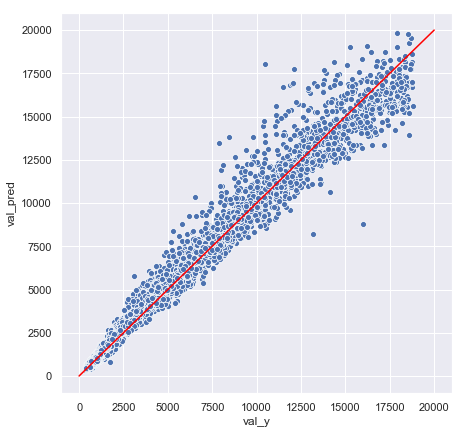

In [191]:
## NN with Entity Enmbedding
print(df_test_nn.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_nnEmbed, x="val_y", y="val_pred")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

10788


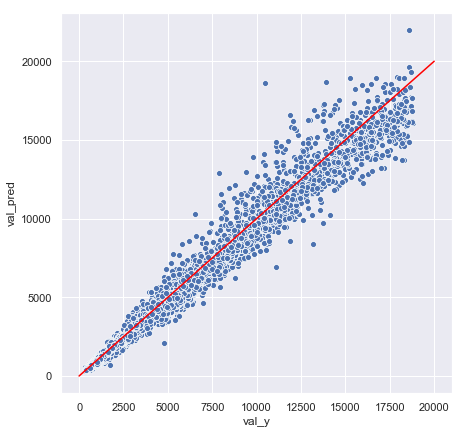

In [192]:
## Base Model NN
print(df_test_nn.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_nn, x="val_y", y="val_pred")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

10788


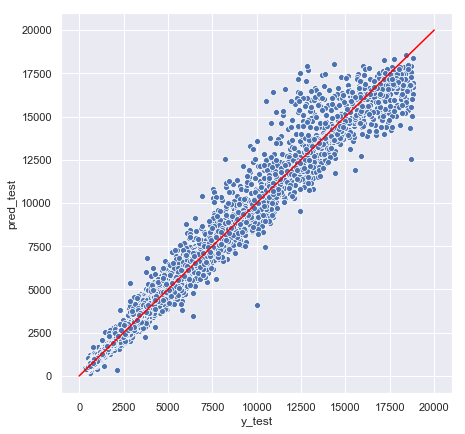

In [193]:
## Base Model XGB
print(df_test_xgb.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_xgb, x="y_test", y="pred_test")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

## XGBoost Using Entity Embedding

In [201]:
list_embedding

[array([[-0.02020033,  1.1072084 ,  0.02063567, -0.55619067],
        [ 0.21211146,  0.29790136, -0.2567385 , -0.29398265],
        [-0.19812824,  0.04006314, -0.26353794, -0.11218845],
        [-0.08748369,  0.4575827 , -0.323409  ,  0.11473224],
        [ 0.14735593,  0.10549642, -0.3353981 , -0.10398255]],
       dtype=float32),
 array([[ 0.07831994, -0.04676175,  0.13671169,  0.3852005 , -0.16392162,
          0.2180117 ],
        [-0.01331629,  0.01896157,  0.30285004,  0.27667734, -0.09500176,
          0.07329107],
        [ 0.03463135,  0.12461855,  0.34007835,  0.16117978,  0.0665288 ,
          0.04910448],
        [-0.02897913, -0.11728293,  0.27739862,  0.00551082,  0.22755979,
          0.11693531],
        [-0.26068592,  0.05589813,  0.3027393 , -0.23657571,  0.03335849,
          0.3523711 ],
        [-0.04881401, -0.2031173 ,  0.59514177, -0.48394257, -0.2459507 ,
          0.16329019],
        [ 0.3732626 , -0.00686252,  0.6621151 , -0.7987882 , -0.01557425,
          

TSNE


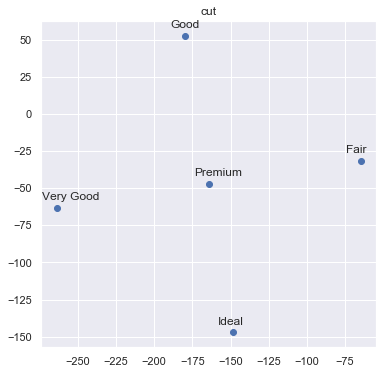

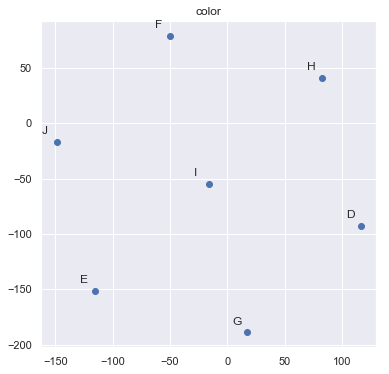

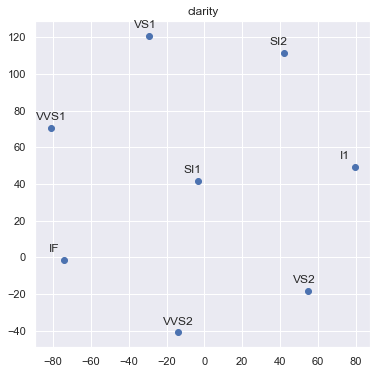

In [217]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

diamonds = sns.load_dataset("diamonds")

print("TSNE")
for idx, col in zip(range(3), ["cut", "color", "clarity"]):
    names = np.unique(diamonds[col])
    X_embedded = TSNE(n_components=2).fit_transform(list_embedding[idx])
    plt.figure(figsize=(6,6))
    plt.scatter(-X_embedded[:, 0], -X_embedded[:, 1])
    plt.title(col)
    for i, txt in enumerate(names):
        plt.annotate(txt, (-X_embedded[i, 0],-X_embedded[i, 1]), xytext = (-15, 8), textcoords = 'offset points')

PCA


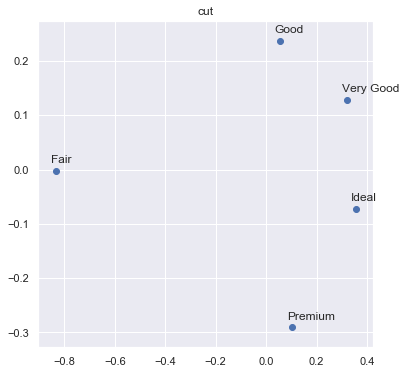

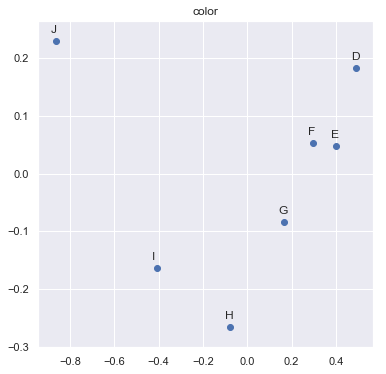

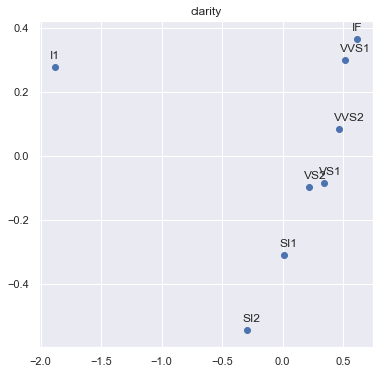

In [220]:
print("PCA")
for idx, col in zip(range(3), ["cut", "color", "clarity"]):
    names = np.unique(diamonds[col])
    X_embedded = PCA(n_components=2).fit_transform(list_embedding[idx])
    plt.figure(figsize=(6,6))
    plt.scatter(-X_embedded[:, 0], -X_embedded[:, 1])
    plt.title(col)
    for i, txt in enumerate(names):
        plt.annotate(txt, (-X_embedded[i, 0],-X_embedded[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [205]:
diamonds = sns.load_dataset("diamonds")

def feature_engineering(data):
    df = pd.DataFrame()
    i = 0
    for col in data.columns:
        embedded = []
        if type(data[col].iloc[0]) == str:
            le = LabelEncoder()
            data[col] = le.fit_transform(np.array(data[col]))
            embedded = [list_embedding[i][val].tolist() for val in data[col]]
            cols = []
            for j in range(len(embedded[0])):
                cols += ["{}{}".format(col,j+1)]
            print(cols)
            tmp = pd.DataFrame(embedded, columns=cols)
            df = pd.concat([df, tmp], axis=1)
            i += 1
    return data, df


diamonds, df_embedded = feature_engineering(diamonds)
diamonds = pd.concat([diamonds, df_embedded], axis=1).drop(["cut", "color", "clarity"], axis=1)
diamonds.head()

['cut1', 'cut2', 'cut3', 'cut4']
['color1', 'color2', 'color3', 'color4', 'color5', 'color6']
['clarity1', 'clarity2', 'clarity3', 'clarity4', 'clarity5', 'clarity6', 'clarity7']


,carat,depth,table,price,x,y,z,cut1,cut2,cut3,...,color4,color5,color6,clarity1,clarity2,clarity3,clarity4,clarity5,clarity6,clarity7
0,0.23,61.5,55.0,326,3.95,3.98,2.43,-0.198128,0.040063,-0.263538,...,0.276677,-0.095002,0.073291,0.268333,-0.164430,0.017550,-0.334223,0.151727,-0.673403,-0.441620
1,0.21,59.8,61.0,326,3.89,3.84,2.31,-0.087484,0.457583,-0.323409,...,0.276677,-0.095002,0.073291,0.046271,0.143378,0.265316,-0.025724,0.161024,-0.477111,-0.212452
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.212111,0.297901,-0.256739,...,0.276677,-0.095002,0.073291,0.043641,-0.089392,0.046089,0.077382,0.091105,-0.236655,0.256393
3,0.29,62.4,58.0,334,4.20,4.23,2.63,-0.087484,0.457583,-0.323409,...,-0.483943,-0.245951,0.163290,0.234326,0.120415,0.073546,-0.092443,0.083352,-0.117641,0.120997
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.212111,0.297901,-0.256739,...,-0.798788,-0.015574,0.547004,0.268333,-0.164430,0.017550,-0.334223,0.151727,-0.673403,-0.441620


In [206]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

params = {
          "objective": "reg:linear",
          "eval_metric": "mae",
          "nthread": 4,
          "learning_rate": 0.05,
          "min_child_weight": 0,
          "max_depth": 8,
          "gamma": 0,
          "subsample":0.9,
          "colsample_bytree": 0.9,
          "reg_lambda": 0,
          "silent": 1,
          "seed": 42
         }

def MAPE(trues, preds):
    return np.mean(np.absolute(trues - preds)/trues)

def modeling_xgb(data, params):
    ## Prepare for Xgboost
    #Split dataset to train and test data: Hold-Out
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["price", "x", "y", "z"], axis=1), data["price"], test_size=0.2, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
    print("学習データ数: {}, 検証データ数: {}, テストデータ数: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))
    print("X_train: {}\ny_train:{}".format(X_train.iloc[0], y_train.iloc[0]))
    #Get labels
    feature_names = np.array(X_train.columns)
    #Change data-type to matrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.tolist(), feature_names = feature_names)
    dvalid = xgb.DMatrix(X_valid.values, label=y_valid.tolist(), feature_names = feature_names)
    dtest = xgb.DMatrix(X_test.values, label=y_test.tolist(), feature_names = feature_names)
    
    print("process training..")
    model = xgb.train(params, dtrain, num_boost_round=4000, evals=[(dtrain, 'train'), (dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=100)
    
    print("process evaluation...")
    pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    
    MAE_valid = mean_absolute_error(y_valid, pred_valid)
    MAE_test = mean_absolute_error(y_test, pred_test)
    MAPE_valid = MAPE(y_valid, pred_valid)
    MAPE_test = MAPE(y_test, pred_test)
    
    #結果出力用
    df_valid = pd.DataFrame(data = {
        "y_valid": y_valid,
        "pred_valid": pred_valid
    })
    df_test = pd.DataFrame(data = {
        "y_test": y_test,
        "pred_test": pred_test
    })
    
    print("MAE_valid：{}  ".format(round(MAE_valid)) )
    print("MAE_test：{}  ".format(round(MAE_test)) )
    print("MAPE_valid：{}  ".format(round(MAPE_valid,4)) )
    print("MAPE_test：{}  ".format(round(MAPE_test,4)) )
    
    return df_valid, df_test

df_valid_xgb2, df_test_xgb2 = modeling_xgb(diamonds, params)

学習データ数: 34521, 検証データ数: 8631, テストデータ数: 10788
X_train: carat        1.160000
depth       60.800000
table       65.000000
cut1         0.212111
cut2         0.297901
cut3        -0.256739
cut4        -0.293983
color1       0.034631
color2       0.124619
color3       0.340078
color4       0.161180
color5       0.066529
color6       0.049104
clarity1     0.268333
clarity2    -0.164430
clarity3     0.017550
clarity4    -0.334223
clarity5     0.151727
clarity6    -0.673403
clarity7    -0.441620
Name: 6881, dtype: float64
y_train:4131
process training..
[0]	train-mae:3754.53	eval-mae:3692.52
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:559.111	eval-mae:556.518
[200]	train-mae:442.159	eval-mae:443.124
[300]	train-mae:381.411	eval-mae:384.907
[400]	train-mae:336.83	eval-mae:342.902
[500]	train-mae:314.803	eval-mae:324.073
[600]	train-mae:297.902	eval-mae:311.309
[700]	train-mae:288.82

In [208]:
# Stopping. Best iteration:
# [2005]	train-mae:214.14	eval-mae:274.096
print( MAPE(df_test_xgb2.y_test, df_test_xgb2.pred_test) )
print( mean_absolute_error(df_test_xgb2.y_test, df_test_xgb2.pred_test) )

0.07701970953010226
275.2303338409752


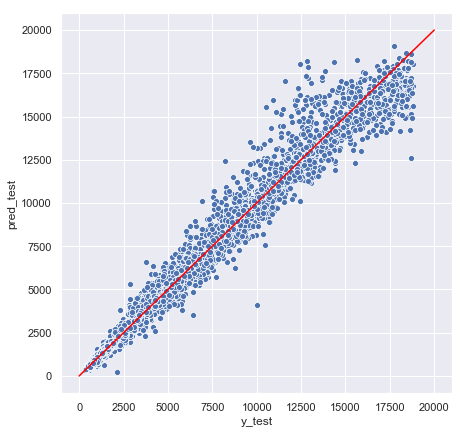

In [209]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_xgb2, x="y_test", y="pred_test")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

## References


- [カテゴリー変数に embedding layer を用いたNeural Net](http://puyokw.hatenablog.com/entry/2016/05/22/090000)
    - Entity Embedding について解説した日本語のブログ
- [Entity Embeddings of Categorical Variables（論文）](https://arxiv.org/abs/1604.06737)
    - arxiv
- [entron/entity-embedding-rossmann（Github）](https://github.com/entron/entity-embedding-rossmann)
    - Github にコードが公開されている
- [Code sharing, 3rd place, category embedding with deep neural network（Kaggle）](https://www.kaggle.com/c/rossmann-store-sales/discussion/17974)
    - Rossmann Store Sales コンペで用いられ、3rd Place に入賞した
- [KerasでEmbedding](http://kento1109.hatenablog.com/entry/2017/12/02/114515)
    - Embedding の動きの確認ができる（ある値の表現力が高まることが確認できる）
- [Embeddingレイヤー（Keras 公式）](https://keras.io/ja/layers/embeddings/)

<p>

- kaggle での利用例
    - [Entity Embedding Neural Net by Joe Eddy](https://www.kaggle.com/aquatic/entity-embedding-neural-net)
    - [Entity Embedding Neural Network Keras [LB 0.748] by David Lobstein](https://www.kaggle.com/astrus/entity-embedding-neural-network-keras-lb-0-748)
    - [Deep learning with Entity Embeddings by DHoa](https://www.kaggle.com/dienhoa/deep-learning-with-entity-embeddings)